# DOST AI Summer School 2017
# Multinomial Naive Bayes Spam Classifier

Prepared by Jerelyn Co (ADMU) and Hadrian Paulo Lim (ADMU) 

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Practicals: Spam Filtering with Multinomial Naive Bayes Classifier

## Agenda

2. Representing text as numerical data
3. Reading a text-based dataset into pandas
4. Vectorizing our dataset
5. Building and evaluating a model
6. Comparing models
7. Examining a model for further insight
9. Tuning the vectorizer (challenge)

## Part 1: Representing text as numerical data

In [2]:
# example text for model training
simple_train = ['call you tonight', 'Call me a cab', 'please call me... PLEASE!']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

We will use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to "convert text into a matrix of token counts":

In [3]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [4]:
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
# examine the fitted vocabulary
vect.get_feature_names()

['cab', 'call', 'me', 'please', 'tonight', 'you']

In [6]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [7]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

In [8]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

In [9]:
# check the type of the document-term matrix
type(simple_train_dtm)

scipy.sparse.csr.csr_matrix

In [10]:
# examine the sparse matrix contents
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have **many feature values that are zeros** (typically more than 99% of them).

> For instance, a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.

> In order to be able to **store such a matrix in memory** but also to **speed up operations**, implementations will typically use a **sparse representation** such as the implementations available in the `scipy.sparse` package.

In [11]:
# example text for model testing
simple_test = ["please don't call me"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [12]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]])

In [13]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 3: Reading a text-based dataset into pandas

In [14]:
# read file into pandas using a relative path
path = 'data/spam_ham.csv'
spam_ham = pd.read_csv(path, header=0, names=['label', 'location','message'])
spam_ham.drop('location', axis=1, inplace=True)
spam_ham.dropna(inplace=True)

In [15]:
# examine the shape
spam_ham.shape

(30974, 2)

In [16]:
# examine the first 10 rows
spam_ham.head(10)

,label,message
0,spam,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...
1,spam,Academic Qualifications available from prestig...
2,ham,Greetings all. This is to verify your subscrip...
3,spam,try chauncey may conferred the luscious not co...
4,ham,"It's quiet. Too quiet. Well, how about a straw..."
5,ham,It's working here. I have departed almost tota...
6,spam,The OIL sector is going crazy. This is our wee...
7,spam,Little magic. Perfect weekends.http://othxu.rz...
8,ham,Greetings all. This is a mass acknowledgement ...
9,spam,"Hi, L C P A X V V e I r m a A I v A o b n L A ..."


In [17]:
# examine the class distribution
spam_ham.label.value_counts()

spam    19280
ham     11694
Name: label, dtype: int64

In [18]:
# convert label to a numerical variable
spam_ham['label_num'] = spam_ham.label.map({'ham':0, 'spam':1})

In [19]:
# check that the conversion worked
spam_ham.head(10)

,label,message,label_num
0,spam,LUXURY WATCHES - BUY YOUR OWN ROLEX FOR ONLY $...,1
1,spam,Academic Qualifications available from prestig...,1
2,ham,Greetings all. This is to verify your subscrip...,0
3,spam,try chauncey may conferred the luscious not co...,1
4,ham,"It's quiet. Too quiet. Well, how about a straw...",0
5,ham,It's working here. I have departed almost tota...,0
6,spam,The OIL sector is going crazy. This is our wee...,1
7,spam,Little magic. Perfect weekends.http://othxu.rz...,1
8,ham,Greetings all. This is a mass acknowledgement ...,0
9,spam,"Hi, L C P A X V V e I r m a A I v A o b n L A ...",1


In [20]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = spam_ham.message
y = spam_ham.label_num
print(X.shape)
print(y.shape)

(30974,)
(30974,)


In [21]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23230,)
(7744,)
(23230,)
(7744,)


## Part 4: Vectorizing our dataset

In [22]:
# instantiate the vectorizer
vect = CountVectorizer()

In [23]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
# examine the fitted vocabulary
vect.get_feature_names()

['00',
 '000',
 '0000',
 '000000',
 '0000000',
 '00000000',
 '000000000',
 '00000000000000',
 '000000000000000000000000000000049999999999999e9',
 '0000000000000000000000000000000500000000000000e9',
 '0000000000000016666l',
 '0000000000000017d',
 '00000000000000e',
 '0000000000status',
 '0000000001d0',
 '0000000001l0',
 '0000000010000000004l0',
 '0000000016',
 '000000001d0',
 '00000000message',
 '00000000x',
 '00000001',
 '00000001irdecode',
 '00000004',
 '00000010',
 '00000010pwm',
 '00000011',
 '0000001196',
 '00000049',
 '0000005',
 '000000eb',
 '000001',
 '00000100',
 '00000100shaftencoder',
 '000001bdaaa0',
 '000001bdc5a5',
 '000001bdcaf3',
 '000001bdd411',
 '000001bdd98c',
 '000001bdda70',
 '000001bde0a0',
 '000001bed6b7',
 '000001c64310',
 '000001c64562',
 '000001c64585',
 '000001c64615',
 '000001c6465f',
 '000001c6468e',
 '000001c676b8',
 '0000020',
 '0000040',
 '0000040b',
 '0000040c',
 '000005',
 '0000060',
 '00001',
 '000010',
 '0000100',
 '00001000',
 '00001004',
 '00001008'

In [25]:
# transform training data into a 'document-term matrix'
X_train_dtm = vect.transform(X_train)

In [26]:
# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [27]:
# examine the document-term matrix
X_train_dtm

<23230x154169 sparse matrix of type '<class 'numpy.int64'>'
	with 2307898 stored elements in Compressed Sparse Row format>

In [28]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<7744x154169 sparse matrix of type '<class 'numpy.int64'>'
	with 734621 stored elements in Compressed Sparse Row format>

## Part 5: Building and evaluating a model

We will use [multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> The multinomial Naive Bayes classifier is suitable for classification with **discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [29]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [30]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 34.9 ms, sys: 9.63 ms, total: 44.5 ms
Wall time: 43.5 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [32]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.98514979338842978

In [33]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[2885,    8],
       [ 107, 4744]])

In [34]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class, digits=4))

             precision    recall  f1-score   support

          0     0.9642    0.9972    0.9805      2893
          1     0.9983    0.9779    0.9880      4851

avg / total     0.9856    0.9851    0.9852      7744



In [35]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([  1.00000000e+00,   6.49899204e-21,   1.00000000e+00, ...,
         1.37521821e-22,   1.00000000e+00,   1.00000000e+00])

In [36]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.99703632827922983

## Part 7: Examining a model for further insight

We will examine the our **trained Naive Bayes model** to calculate the approximate **"spamminess" of each token**.

In [37]:
# store the vocabulary of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

154169

In [38]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['00', '000', '0000', '000000', '0000000', '00000000', '000000000', '00000000000000', '000000000000000000000000000000049999999999999e9', '0000000000000000000000000000000500000000000000e9', '0000000000000016666l', '0000000000000017d', '00000000000000e', '0000000000status', '0000000001d0', '0000000001l0', '0000000010000000004l0', '0000000016', '000000001d0', '00000000message', '00000000x', '00000001', '00000001irdecode', '00000004', '00000010', '00000010pwm', '00000011', '0000001196', '00000049', '0000005', '000000eb', '000001', '00000100', '00000100shaftencoder', '000001bdaaa0', '000001bdc5a5', '000001bdcaf3', '000001bdd411', '000001bdd98c', '000001bdda70', '000001bde0a0', '000001bed6b7', '000001c64310', '000001c64562', '000001c64585', '000001c64615', '000001c6465f', '000001c6468e', '000001c676b8', '0000020']


In [39]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['３ｄバーチャルｓｅｘメーカー', '４名紹介http', '４月度新規メンバー様応援企画パーティー開催予定', '４月２３日', '５月までのようなので興味のある方はお早めに', '５月中週末３人か４人ぐらいで', '５００円分のポイントが完全無料で自動追加されます', '６名のみとなります', 'ａ型', 'ａ美様現在未亡人でいらっしゃいます', 'ｂ９６', 'ｆカップ', 'ｇａｌ誌多数掲載', 'ｇｏｏｄ', 'ｇｒａｎｄｅｅ', 'ｇｒａｎｄｅｅの理念やシステムのご紹介', 'ｇｗこそ出会いのチャンスhttp', 'ｇｗです', 'ｇｗはこういう女の子と過ごしたいっす', 'ｇｗ特典あり', 'ｈなこと大好きな人ばかり', 'ｈな女の子が多いので', 'ｈな欲望や願望を胸に秘め', 'ｈにそんなに興味なかったのと少し怖いのもあるため', 'ｈのお相手しただけで', 'ｈゲームメーカーの決定版', 'ｈ度', 'ｈ目的の出会いも簡単です', 'ｈ８６', 'ｋ村', 'ｍ子様セーリングクルーザーをお持ちで', 'ｍ字開脚オナニーを机の下から盗撮', 'ｍａｉｌでのサポートは２４時間対応です', 'ｎ藤', 'ｏｌ', 'ｐｃ', 'ｐｃから簡単プロフィール作成', 'ｓクラス専門店', 'ｓ子様秘密が条件で', 'ｓｅｘを求めている', 'ｓｅｘを求めているのです', 'ｓｍ', 'ｔ165', 'ｔバックは', 'ｔバックはいていたらおならが左右に分散するのでなんか変な感じですけどね', 'ｔバックを購入しました', 'ｔ島', 'ｔ谷', 'ｗ６２', 'ｙ里様お互いがくつろげるような']


In [40]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  2.09000000e+03,   4.46000000e+02,   3.71000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.39200000e+03,   5.36400000e+03,   2.00000000e+00, ...,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00]])

In [41]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 154169)

In [42]:
# number of times each token appears across all HAM messages
ham_token_count = nb.feature_count_[0, :]
ham_token_count

array([ 2090.,   446.,   371., ...,     0.,     0.,     0.])

In [43]:
# number of times each token appears across all SPAM messages
spam_token_count = nb.feature_count_[1, :]
spam_token_count

array([  3.39200000e+03,   5.36400000e+03,   2.00000000e+00, ...,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00])

In [44]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'ham':ham_token_count, 'spam':spam_token_count}).set_index('token')
tokens.head()

,ham,spam
token,,
00,2090.0,3392.0
000,446.0,5364.0
0000,371.0,2.0
000000,19.0,44.0
0000000,1.0,0.0


In [45]:
# examine 5 random DataFrame rows
tokens.sample(5)

,ham,spam
token,,
precious,10.0,76.0
mehmel,1.0,0.0
statepark,2.0,0.0
cutdown,3.0,0.0
bloodsupply,1.0,0.0


In [46]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([  8801.,  14429.])

Before we can calculate the "spamminess" of each token, we need to avoid **dividing by zero** and account for the **class imbalance**.

In [47]:
# add 1 to ham and spam counts to avoid dividing by 0
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1
tokens.sample(5)

,ham,spam
token,,
squared,11.0,1.0
hopeless,3.0,3.0
削除して下さい,1.0,5.0
shortcuts,20.0,1.0
resolutionof,4.0,1.0


In [48]:
# convert the ham and spam counts into frequencies
tokens['ham'] = tokens.ham / nb.class_count_[0]
tokens['spam'] = tokens.spam / nb.class_count_[1]
tokens.sample(5)

,ham,spam
token,,
setsdate,0.000227,0.000069
memorial,0.001704,0.000069
0800received,0.001136,0.000069
goofy,0.001250,0.000069
senden,0.000454,0.000347


In [49]:
# calculate the ratio of spam-to-ham for each token
tokens['spam_ratio'] = tokens.spam / tokens.ham
tokens.sample(5)

,ham,spam,spam_ratio
token,,,
factorin,0.000227,0.000069,0.304976
9700,0.000795,0.000069,0.087136
detain,0.000114,0.000762,6.709474
otheranalogue,0.000341,0.000069,0.203317
overloaded,0.000795,0.000069,0.087136


In [50]:
# examine the DataFrame sorted by spam_ratio
# note: use sort() instead of sort_values() for pandas 0.16.2 and earlier
tokens.sort_values('spam_ratio', ascending=False)

,ham,spam,spam_ratio
token,,,
product_table,0.000114,0.601012,5289.505302
0px,0.000341,0.681336,1998.813293
13px,0.000114,0.189133,1664.559498
15px,0.000114,0.188994,1663.339594
proms,0.000114,0.150599,1325.426086
professionaladobe,0.000114,0.150599,1325.426086
hereopt,0.000114,0.126620,1114.382632
fff,0.000114,0.115185,1013.740523
compacted_description,0.000114,0.112967,994.222053


In [51]:
# look up the spam_ratio for a given token
# Note that the specified token, adobe, can change due to the nature of randomness
tokens.loc['adobe', 'spam_ratio']

32.742940193913022

## Part 9: Tuning the vectorizer (Challenge)

Thus far, we have been using the default parameters of [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

In [52]:
# show default parameters for CountVectorizer
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

However, the vectorizer is worth tuning, just like a model is worth tuning! Here are a few parameters that you might want to tune:

- **stop_words:** string {'english'}, list, or None (default)
    - If 'english', a built-in stop word list for English is used.
    - If a list, that list is assumed to contain stop words, all of which will be removed from the resulting tokens.
    - If None, no stop words will be used.

In [53]:
# remove English stop words
vect = CountVectorizer(stop_words='english')

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [54]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [55]:
# ignore terms that appear in more than 50% of the documents
vect = CountVectorizer(max_df=0.5)

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [56]:
# only keep terms that appear in at least 2 documents
vect = CountVectorizer(min_df=2)

**Guidelines for tuning CountVectorizer:**

- Use your knowledge of the **problem** and the **text**, and your understanding of the **tuning parameters**, to help you decide what parameters to tune and how to tune them.

Tasks:
1. **Experiment**, and let the data tell you the best approach!
    * Try using GridSearch on the CountVectorizer!
2. Try to reduce or increase the features and get a better score on the previous model. 
    * Score above a 99.5%? Tell us! :)

In [57]:
vect = CountVectorizer(stop_words='english', ngram_range=(1, 7), max_df=0.95)
X_trimmed = vect.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23230, 8561201)
(7744, 8561201)
(23230,)
(7744,)


In [58]:
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

8561201

In [59]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print(classification_report(y_test, nb.predict(X_test), digits=4))

             precision    recall  f1-score   support

          0     0.9926    0.9966    0.9946      2973
          1     0.9979    0.9954    0.9966      4771

avg / total     0.9959    0.9959    0.9959      7744



In [60]:
ham_token_count = nb.feature_count_[0, :]
spam_token_count = nb.feature_count_[1, :]
tokens = pd.DataFrame({'token':X_train_tokens, 'ham':ham_token_count, 'spam':spam_token_count}).set_index('token')

In [61]:
tokens['ham'] = tokens.ham + 1
tokens['spam'] = tokens.spam + 1
tokens['spam_ratio'] = tokens.spam / tokens.ham
tokens.sort_values('spam_ratio')

,ham,spam,spam_ratio
token,,,
nil nil,3325.0,1.0,0.000301
nil nil nil,2846.0,1.0,0.000351
nil nil nil nil,2370.0,1.0,0.000422
nil nil nil nil nil,1926.0,1.0,0.000519
cert,1813.0,1.0,0.000552
hb,1645.0,1.0,0.000608
node,1516.0,1.0,0.000660
nil nil nil nil nil nil,1506.0,1.0,0.000664
nodes,1438.0,1.0,0.000695


## Part 10: Tuning the Laplacian Correction Factor (Challenge)

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html):

> class sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

> Parameters:	
alpha : float, optional (default=1.0)
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

One of the parameters that we can tune in training a Multinomial Naive Bayes Classifier is the Laplacian Correction Factor.

Tasks:
1. Tweak the correction factor from 0-3 in increments of 0.1, 5, and 10, thus training multiple classifiers.
2. Plot the precision-recall curves for these classifiers to compare and contrast.

In [62]:
classifiers = [MultinomialNB(alpha=i) for i in np.concatenate((np.arange(0, 3.1, 0.1), [5, 10]))]

In [63]:
for i in classifiers:
    i.fit(X_train, y_train)

/Users/hadrian/anaconda/lib/python3.6/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


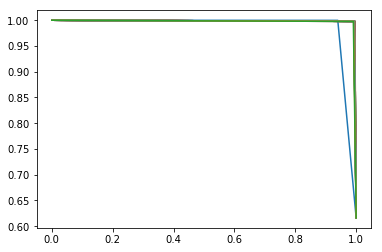

In [64]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
for i in classifiers:
    precision, recall, _ = precision_recall_curve(y_test.ravel(),
        i.predict(X_test).ravel())
    average_precision = average_precision_score(y_test, i.predict(X_test).ravel(),
                                                         average="micro")
    plot(recall, precision,
             label='micro-average Precision-recall curve (area = {0:0.2f})'
                   ''.format(average_precision))

In [65]:
for i in classifiers:
    print(i.get_params()['alpha'])
    print(classification_report(y_test, i.predict(X_test),digits=4))

0.0
             precision    recall  f1-score   support

          0     0.9117    0.9997    0.9536      2973
          1     0.9998    0.9396    0.9688      4771

avg / total     0.9659    0.9627    0.9630      7744

0.1
             precision    recall  f1-score   support

          0     0.9933    0.9963    0.9948      2973
          1     0.9977    0.9958    0.9967      4771

avg / total     0.9960    0.9960    0.9960      7744

0.2
             precision    recall  f1-score   support

          0     0.9930    0.9963    0.9946      2973
          1     0.9977    0.9956    0.9966      4771

avg / total     0.9959    0.9959    0.9959      7744

0.3
             precision    recall  f1-score   support

          0     0.9926    0.9966    0.9946      2973
          1     0.9979    0.9954    0.9966      4771

avg / total     0.9959    0.9959    0.9959      7744

0.4
             precision    recall  f1-score   support

          0     0.9926    0.9966    0.9946      2973
          1  